Generate temperature, salinity, and nutrient initial files to use in MITgcm runs.

Functions to generate T, S, and nutrient initial conditions (profiles) for MITgcm
=========================================================================

Choose between linear profile and profile interpolated from Pthways Curise 2013 at Barkley Canyon data.
K. Ramos-Musalem

In [1]:

import os

import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import nanmean

from math import *

import struct



%matplotlib inline

In [2]:
def iniTracer(xsize, ysize, IniDepth, IniProfile, InterpDepth):
    
    InterpProfile = np.interp(InterpDepth, IniDepth , IniProfile)
    
    tracer = np.zeros((xsize, ysize, len(InterpDepth)))
    
    for ii in np.arange(xsize):
        
        for jj in np.arange(ysize):
            
            for kk in np.arange(len(InterpDepth)):
        
                tracer[ii,jj,kk]=InterpProfile[kk] 
            

    return tracer

In [3]:
def iniTracerLin(xsize, ysize, TopVal,BotVal, Depth ):
    
    # Generate linear nutrient profile (i.e. C(Depth)= IniVal*Depth) 
    
    M = (BotVal-TopVal)/(Depth[len(Depth)-1]-Depth[0])
    b = (TopVal - M*Depth[0])*np.ones((len(Depth),1))
    
    tracer = np.zeros((xsize, ysize, len(Depth)))
    
    for ii in np.arange(xsize):
        for jj in np.arange(ysize):
            for kk in np.arange(len(Depth)):
                tracer[ii,jj,kk]=M*Depth[kk]+b[kk] 
            

    return tracer

In [4]:
def iniTracerLinHor(xsize, zsize, TopVal,BotVal, yvec ):
    
    # Generate linear nutrient profile (i.e. C(yvec)= IniVal*yvec) 
    
    M = (BotVal-TopVal)/(yvec[len(yvec)-1]-yvec[0])
    b = (TopVal - M*yvec[0])*np.ones((len(yvec),1))
    
    tracer = np.zeros((xsize,len(yvec),zsize))
    
    for ii in np.arange(xsize):
        for jj in np.arange(zsize):
            for kk in np.arange(len(yvec)):
                tracer[ii,kk,jj]=M*yvec[kk]+b[kk] 
            

    return tracer

In [5]:
def iniTracerCnt(xsize, ysize, CntVal, Depth ):
    # Generate constant nutrient profile  
    
    tracer = np.ones((xsize, ysize, len(Depth)))
    tracer = tracer*CntVal
    

    return tracer

In [6]:
# Profile values form interp nutrient data from Falkor (see NutrientProfilesFalkor.ipynb)

dt = np.dtype('>f8')  # float 64 big endian


nx = 360
ny = 360
nz = 90

# Depth values

depth = [5.,20.,30.,50.,70.,100.,150.,170.,200.,300.,400.,500.,600.,700.,800.,1000.,1200.] #values form interp nutrient data 
                                                                                            # from Falkor (see NutrientProfilesFalkor.ipynb)

## 90 layers
zi = (5,10,	15,	20,	25,	30,	35,	40,	45,	50,	55,	60,	65,	70,	75,	80,	85,	90,	95,	100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,180,190,200,210,220,230,240,250,260,280,300,320,340,360,380,400,420,440,460,480,500,520,540,560,580,600,620,640,660,680,700,720,740,760,780,800,820,840,860,880,900,920,940,960,980,1000,1020,1040,1060,1080,1100,1120,1140,1160,1180,1200)


(90, 360, 360)


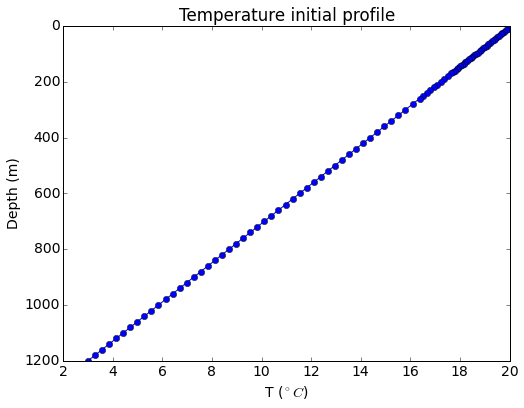

In [12]:
#Temperature

temp = [13.92419179,  10.19468641,   8.58686415,   7.45058646,
         7.28092498,   7.19139622,   6.92763903,   6.85987391,
         6.68035617,   6.11261289,   5.65138553,   5.30145515,
         4.94772486,   4.53669634,   4.17122877,   3.66913223,   3.21469724]  #Falkor Temp

#Temp=iniTracer(nx,ny,depth,temp,zi)
Temp = iniTracerLin(nx,ny,20.0,3.0,zi)

# Save binary file
tmpfile = "%dx%dx%d/Lintmp_N006_%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Temp2 = Temp.transpose((2,0,1)) # To keep fortran order when writing as C binary
print(np.shape(Temp2))
Temp2.astype(dt).tofile(fileobj,"")
fileobj.close()


### PLOT
plt.rcParams['contour.negative_linestyle']='solid'

plt.figure(figsize=(8,6))

CS = plt.plot(np.squeeze(Temp[60,45,:]),zi,'bo-')

plt.gca().invert_yaxis()
    
plt.xlabel('T ($^{\circ}C$)')
    
plt.ylabel('Depth (m)')
    
plt.title('Temperature initial profile ')



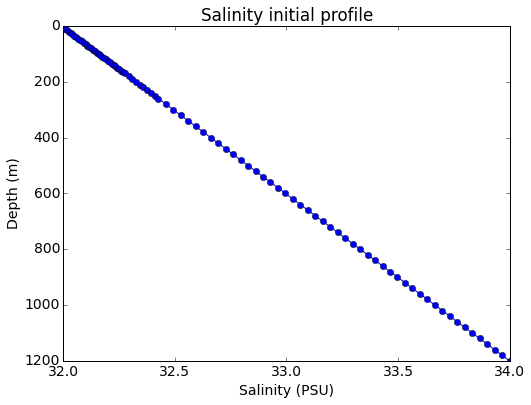

In [8]:
#Salinity

sal = [32.05565615,  32.47904982,  32.69883153,  33.14754095,
        33.45287546,  33.74755425,  33.89389881,  33.9139597 ,
        33.93728968,  33.98439263,  34.04611345,  34.09233602,
        34.14232788,  34.22413622,  34.28826251,  34.37998532,  34.4410795 ] #Falkor Salinity

#Sal = iniTracer(nx,ny,depth,sal,zi)
Sal = iniTracerLin(nx,ny,32.0,34.0,zi)

# Save binary file
tmpfile = "%dx%dx%d/Linsal_N006_%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Sal2 = Sal.transpose((2,0,1)) # To keep fortran order when writing as C binarynp.asfortranarray(Sal)
Sal2.astype(dt).tofile(fileobj,"")
fileobj.close()

### PLOT Contour

plt.rcParams.update({'font.size':14})
plt.rcParams['contour.negative_linestyle']='solid'

plt.figure(figsize=(8,6))

CS = plt.plot(np.squeeze(Sal[60,45,:]),zi,'bo-')

plt.gca().invert_yaxis()
    
plt.xlabel('Salinity (PSU)')
    
plt.ylabel('Depth (m)')
    

plt.title('Salinity initial profile ')



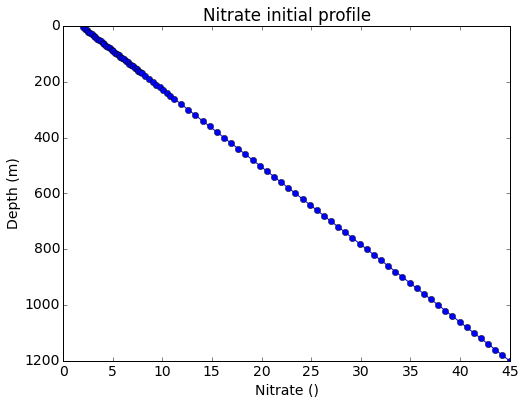

In [9]:
#Nitrate (from annual average)


nit = [  2.20769231,  14.30606356,  20.69884474,  24.54682499,
        27.64221491,  30.40401935,  32.60791595,  33.23055095,
        34.93009381,  37.96639598,  40.48248953,  41.87936656,
        43.16092676,  44.42630919,  44.86319564,  45.33917039,  45.01343725] #Falkor Nitrate

#Nitrate = iniTracer(nx,ny,depth,nit,zi)
Nitrate = iniTracerLin(nx,ny,2.0,45.0,zi)

               
# Save binary file
tmpfile = "%dx%dx%d/Linnit%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Nitrate2 = Nitrate.transpose((2,0,1)) # To keep fortran order when writing as C binary
Nitrate2.astype(dt).tofile(fileobj,"")
fileobj.close()


### PLOT Contour

plt.rcParams.update({'font.size':14})
plt.rcParams['contour.negative_linestyle']='solid'

plt.figure(figsize=(8,6))

CS = plt.plot(np.squeeze(Nitrate[60,45,:]),zi,'bo-')

plt.gca().invert_yaxis()
    
plt.xlabel('Nitrate ()')
    
plt.ylabel('Depth (m)')
    

plt.title('Nitrate initial profile ')


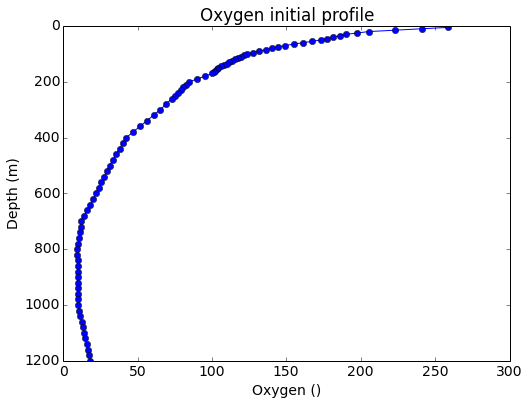

In [8]:
oxy = [ 258.64692308,  205.30523866,  189.93474682,  173.32762752,
        148.99494704,  123.39376698,  104.07073273,  100.34682448,
         84.75278265,   65.32870403,   42.38594405,   31.24731648,
         22.04183918,   12.32014822,    9.56728914,   10.02871031,
         18.18188635] #Falkor Oxygen

Oxygen = iniTracer(nx,ny,depth,oxy,zi)

# Save binary file
tmpfile = "%dx%dx%d/BCCoxy%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Oxygen2 = Oxygen.transpose((2,0,1)) # To keep fortran order when writing as C binary
Oxygen2.astype(dt).tofile(fileobj,"")
fileobj.close()        


### PLOT Contour

plt.rcParams.update({'font.size':14})
plt.rcParams['contour.negative_linestyle']='solid'

plt.figure(figsize=(8,6))

CS = plt.plot(np.squeeze(Oxygen[60,45,:]),zi,'bo-')

plt.gca().invert_yaxis()
    
plt.xlabel('Oxygen ()')
    
plt.ylabel('Depth (m)')
    

plt.title('Oxygen initial profile ')




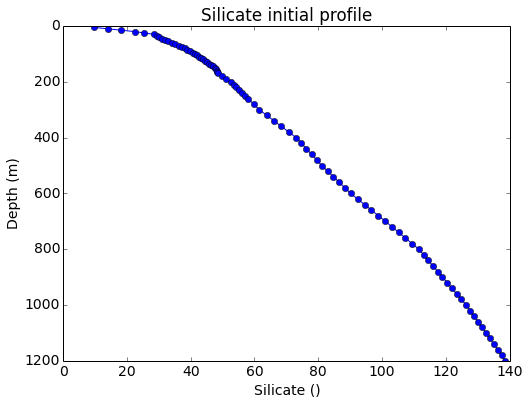

In [9]:
sil = [ 9.77487179,   22.40324386,   28.481157  ,   31.81179168,
         36.35084393,   41.51053289,   47.62601443,   48.57082304,
         52.54408413,   61.52273871,   73.08433615,   81.12181574,
         90.16770523,  101.05308596,  111.55221474,  126.39029233,
        138.72363852 ] #Falkor Silicate

Silicate = iniTracer(nx,ny,depth,sil,zi)

# Save binary file
tmpfile = "%dx%dx%d/BCCsil%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Silicate2 = Silicate.transpose((2,0,1)) # To keep fortran order when writing as C binary
Silicate2.astype(dt).tofile(fileobj,"")
fileobj.close()              



### PLOT Contour

plt.rcParams.update({'font.size':14})
plt.rcParams['contour.negative_linestyle']='solid'

plt.figure(figsize=(8,6))

CS = plt.plot(np.squeeze(Silicate[60,45,:]),zi,'bo-')

plt.gca().invert_yaxis()
    
plt.xlabel('Silicate ()')
    
plt.ylabel('Depth (m)')
    

plt.title('Silicate initial profile ')



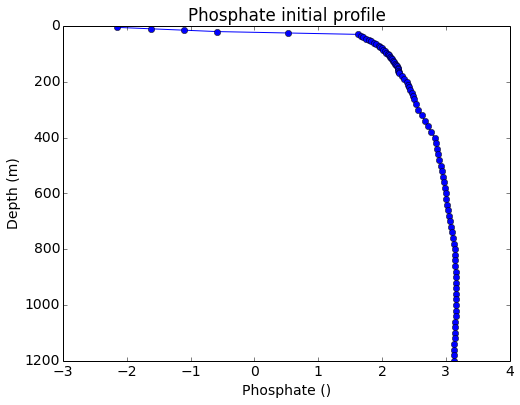

In [10]:
pho = [-2.14848718, -0.58315699,  1.6205616 ,  1.79738767,  1.94555393,
        2.08709737,  2.24576282,  2.27144092,  2.39342327,  2.57196961,
        2.82463189,  2.92081108,  2.99713342,  3.06841061,  3.14757836,
        3.16063801,  3.12403118  ] #Falkor Phosphate

Phosphate = iniTracer(nx,ny,depth,pho,zi)

               
# Save binary file
tmpfile = "%dx%dx%d/BCCpho%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Phosphate2 = Phosphate.transpose((2,0,1)) # To keep fortran order when writing as C binary
Phosphate2.astype(dt).tofile(fileobj,"")
fileobj.close()              



### PLOT Contour

plt.rcParams.update({'font.size':14})
plt.rcParams['contour.negative_linestyle']='solid'

plt.figure(figsize=(8,6))

CS = plt.plot(np.squeeze(Phosphate[60,45,:]),zi,'bo-')

plt.gca().invert_yaxis()
    
plt.xlabel('Phosphate ()')
    
plt.ylabel('Depth (m)')
    

plt.title('Phosphate initial profile ')



Let's check what we wrote...

In [13]:

fileNAME = "%dx%dx%d/Lintmp_N006_%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
tempp=np.fromfile(fileNAME, dt)

In [14]:

temppp=np.reshape(tempp,(nx,ny,len(zi)),order='F')
np.shape(temppp)

(360, 360, 90)

In [15]:
print(max(tempp))


20.0


<matplotlib.colorbar.Colorbar instance at 0x7f1d48c1fd40>

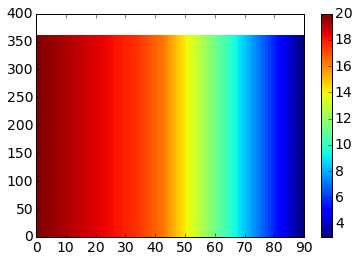

In [16]:
plt.pcolor(temppp[80,:,:])
plt.colorbar()

Generate horizontal tracer gradient file

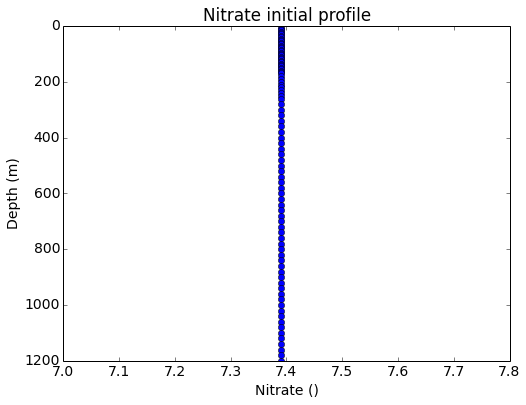

In [16]:
#Nitrate (from annual average)


nit = [  2.20769231,  14.30606356,  20.69884474,  24.54682499,
        27.64221491,  30.40401935,  32.60791595,  33.23055095,
        34.93009381,  37.96639598,  40.48248953,  41.87936656,
        43.16092676,  44.42630919,  44.86319564,  45.33917039,  45.01343725] #Falkor Nitrate

nx = 360
nz = 90
ny = 360

yi = np.arange(ny)
#Nitrate = iniTracer(nx,ny,depth,nit,zi)
NitrateHor = iniTracerLinHor(nx,nz,2.0,45.0,yi)

               
# Save binary file
tmpfile = "%dx%dx%d/LinnitHor%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Nitrate2 = NitrateHor.transpose((2,0,1)) # To keep fortran order when writing as C binary
Nitrate2.astype(dt).tofile(fileobj,"")
fileobj.close()


### PLOT Contour

plt.rcParams.update({'font.size':14})
plt.rcParams['contour.negative_linestyle']='solid'

plt.figure(figsize=(8,6))

CS = plt.plot(np.squeeze(NitrateHor[60,45,:]),zi,'bo-')

plt.gca().invert_yaxis()
    
plt.xlabel('Nitrate ()')
    
plt.ylabel('Depth (m)')
    

plt.title('Nitrate initial profile ')

<matplotlib.colorbar.Colorbar instance at 0x7fc37234a368>

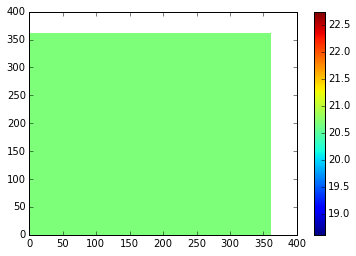

In [17]:
fileNAME = "%dx%dx%d/Lintmp_doubleN_%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
tempp=np.fromfile(fileNAME, dt)

temppp=np.reshape(tempp,(nx,ny,len(zi)),order='F')
np.shape(temppp)

plt.pcolor(temppp[:,:,40])
plt.colorbar()

/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in sqrt


nan